In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import torch
import torchvision
from torchvision import datasets, models
from torchvision.transforms import functional as FT
from torchvision import transforms as T
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import DataLoader, sampler, random_split, Dataset
import copy
import math
from PIL import Image
import cv2
import albumentations as A  # our data augmentation library

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# remove warnings (optional)
import warnings
warnings.filterwarnings("ignore")
from collections import defaultdict, deque
import datetime
import time
from tqdm import tqdm # progress bar
from torchvision.utils import draw_bounding_boxes

In [3]:
# our dataset is in cocoformat, we will need pypcoco tools
from pycocotools.coco import COCO
# Now, we will define our transforms
from albumentations.pytorch import ToTensorV2

In [4]:
def get_transforms(train=False):
    if train:
        transform = A.Compose([
            A.Resize(600, 600), # our input size can be 600px
            A.HorizontalFlip(p=0.3),
            A.VerticalFlip(p=0.3),
            A.RandomBrightnessContrast(p=0.1),
            A.ColorJitter(p=0.1),
            ToTensorV2()
        ], bbox_params=A.BboxParams(format='coco'))
    else:
        transform = A.Compose([
            A.Resize(600, 600), # our input size can be 600px
            ToTensorV2()
        ], bbox_params=A.BboxParams(format='coco'))
    return transform

In [5]:
class AquariumDetection(datasets.VisionDataset):
    def __init__(self, root, split='train', transform=None, target_transform=None, transforms=None):
        # the 3 transform parameters are reuqired for datasets.VisionDataset
        super().__init__(root, transforms, transform, target_transform)
        self.split = split #train, valid, test
        self.coco = COCO(os.path.join(root, split, "_annotations.coco.json")) # annotatiosn stored here
        self.ids = list(sorted(self.coco.imgs.keys()))
        self.ids = [id for id in self.ids if (len(self._load_target(id)) > 0)]
    
    def _load_image(self, id: int):
        path = self.coco.loadImgs(id)[0]['file_name']
        image = cv2.imread(os.path.join(self.root, self.split, path))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        return image
    def _load_target(self, id):
        return self.coco.loadAnns(self.coco.getAnnIds(id))
    
    def __getitem__(self, index):
        id = self.ids[index]
        image = self._load_image(id)
        target = self._load_target(id)
        target = copy.deepcopy(self._load_target(id))
        
        boxes = [t['bbox'] + [t['category_id']] for t in target] # required annotation format for albumentations
        if self.transforms is not None:
            transformed = self.transforms(image=image, bboxes=boxes)
        
        image = transformed['image']
        boxes = transformed['bboxes']
        
        new_boxes = [] # convert from xywh to xyxy
        for box in boxes:
            xmin = box[0]
            xmax = xmin + box[2]
            ymin = box[1]
            ymax = ymin + box[3]
            new_boxes.append([xmin, ymin, xmax, ymax])
        
        boxes = torch.tensor(new_boxes, dtype=torch.float32)
        
        targ = {} # here is our transformed target
        targ['boxes'] = boxes
        targ['labels'] = torch.tensor([t['category_id'] for t in target], dtype=torch.int64)
        targ['image_id'] = torch.tensor([t['image_id'] for t in target])
        targ['area'] = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0]) # we have a different area
        targ['iscrowd'] = torch.tensor([t['iscrowd'] for t in target], dtype=torch.int64)
        return image.div(255), targ # scale images
    def __len__(self):
        return len(self.ids)

In [6]:
#link to dataset:https://www.kaggle.com/datasets/sharansmenon/aquarium-dataset

dataset_path = "Aquarium Combined/Aquarium Combined/"

In [7]:
# import shutil
# shutil.unpack_archive('Aquarium Combined.zip', 'Aquarium Combined')

In [8]:
#load classes
coco = COCO(os.path.join(dataset_path, "train", "_annotations.coco.json"))
categories = coco.cats
n_classes = len(categories.keys())
categories

loading annotations into memory...
Done (t=0.02s)
creating index...
index created!


{0: {'id': 0, 'name': 'creatures', 'supercategory': 'none'},
 1: {'id': 1, 'name': 'fish', 'supercategory': 'creatures'},
 2: {'id': 2, 'name': 'jellyfish', 'supercategory': 'creatures'},
 3: {'id': 3, 'name': 'penguin', 'supercategory': 'creatures'},
 4: {'id': 4, 'name': 'puffin', 'supercategory': 'creatures'},
 5: {'id': 5, 'name': 'shark', 'supercategory': 'creatures'},
 6: {'id': 6, 'name': 'starfish', 'supercategory': 'creatures'},
 7: {'id': 7, 'name': 'stingray', 'supercategory': 'creatures'}}

In [9]:
classes = [i[1]['name'] for i in categories.items()]
classes

['creatures',
 'fish',
 'jellyfish',
 'penguin',
 'puffin',
 'shark',
 'starfish',
 'stingray']

In [10]:
train_dataset = AquariumDetection(root=dataset_path, transforms=get_transforms(True))

loading annotations into memory...
Done (t=0.02s)
creating index...
index created!


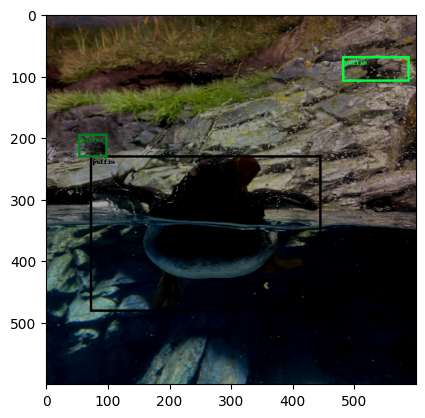

In [11]:
# Lets view a sample
sample = train_dataset[2]
img_int = torch.tensor(sample[0] * 255, dtype=torch.uint8)
plt.imshow(draw_bounding_boxes(
    img_int, sample[1]['boxes'], [classes[i] for i in sample[1]['labels']], width=4
).permute(1, 2, 0))

In [12]:
len(train_dataset)

447

In [13]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
in_features = model.roi_heads.box_predictor.cls_score.in_features # we need to change the head
model.roi_heads.box_predictor = models.detection.faster_rcnn.FastRCNNPredictor(in_features, n_classes)

In [14]:
def collate_fn(batch):
    return tuple(zip(*batch))

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=collate_fn)

In [15]:
images,targets = next(iter(train_loader))
images = list(image for image in images)
targets = [{k:v for k, v in t.items()} for t in targets]
output = model(images, targets) # just make sure this runs without error

In [16]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model = model.to(device)

In [17]:
import sys
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)


In [18]:
#get train_one_epoch function from engine.py
from engine import train_one_epoch, evaluate

In [19]:
num_epochs = 10
for epoch in range(num_epochs):
    train_one_epoch(model, optimizer, train_loader, device, epoch, print_freq=10)
    lr_scheduler.step()



Epoch: [0]  [  0/112]  eta: 0:04:00  lr: 0.000050  loss: 3.2053 (3.2053)  loss_classifier: 2.0666 (2.0666)  loss_box_reg: 0.4059 (0.4059)  loss_objectness: 0.6307 (0.6307)  loss_rpn_box_reg: 0.1021 (0.1021)  time: 2.1482  data: 0.0917  max mem: 3016
Epoch: [0]  [ 10/112]  eta: 0:01:28  lr: 0.000500  loss: 2.2130 (2.2638)  loss_classifier: 1.5741 (1.4445)  loss_box_reg: 0.4059 (0.4052)  loss_objectness: 0.1166 (0.3739)  loss_rpn_box_reg: 0.0181 (0.0403)  time: 0.8664  data: 0.1044  max mem: 3278
Epoch: [0]  [ 20/112]  eta: 0:01:13  lr: 0.000950  loss: 1.3955 (1.7927)  loss_classifier: 0.8217 (1.0632)  loss_box_reg: 0.4803 (0.4436)  loss_objectness: 0.1108 (0.2489)  loss_rpn_box_reg: 0.0252 (0.0369)  time: 0.7347  data: 0.1026  max mem: 3278
Epoch: [0]  [ 30/112]  eta: 0:01:04  lr: 0.001400  loss: 1.1392 (1.5881)  loss_classifier: 0.5077 (0.8822)  loss_box_reg: 0.4803 (0.4557)  loss_objectness: 0.0895 (0.2121)  loss_rpn_box_reg: 0.0241 (0.0382)  time: 0.7333  data: 0.0991  max mem: 3278


In [20]:
model.eval()
torch.cuda.empty_cache()

In [34]:
test_dataset = AquariumDetection(root=dataset_path, split="test", transforms=get_transforms(False))

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


In [24]:
len(test_dataset)

63

In [22]:
img, _ = test_dataset[5]
img_int = torch.tensor(img*255, dtype=torch.uint8)
with torch.no_grad():
    prediction = model([img.to(device)])
    pred = prediction[0]

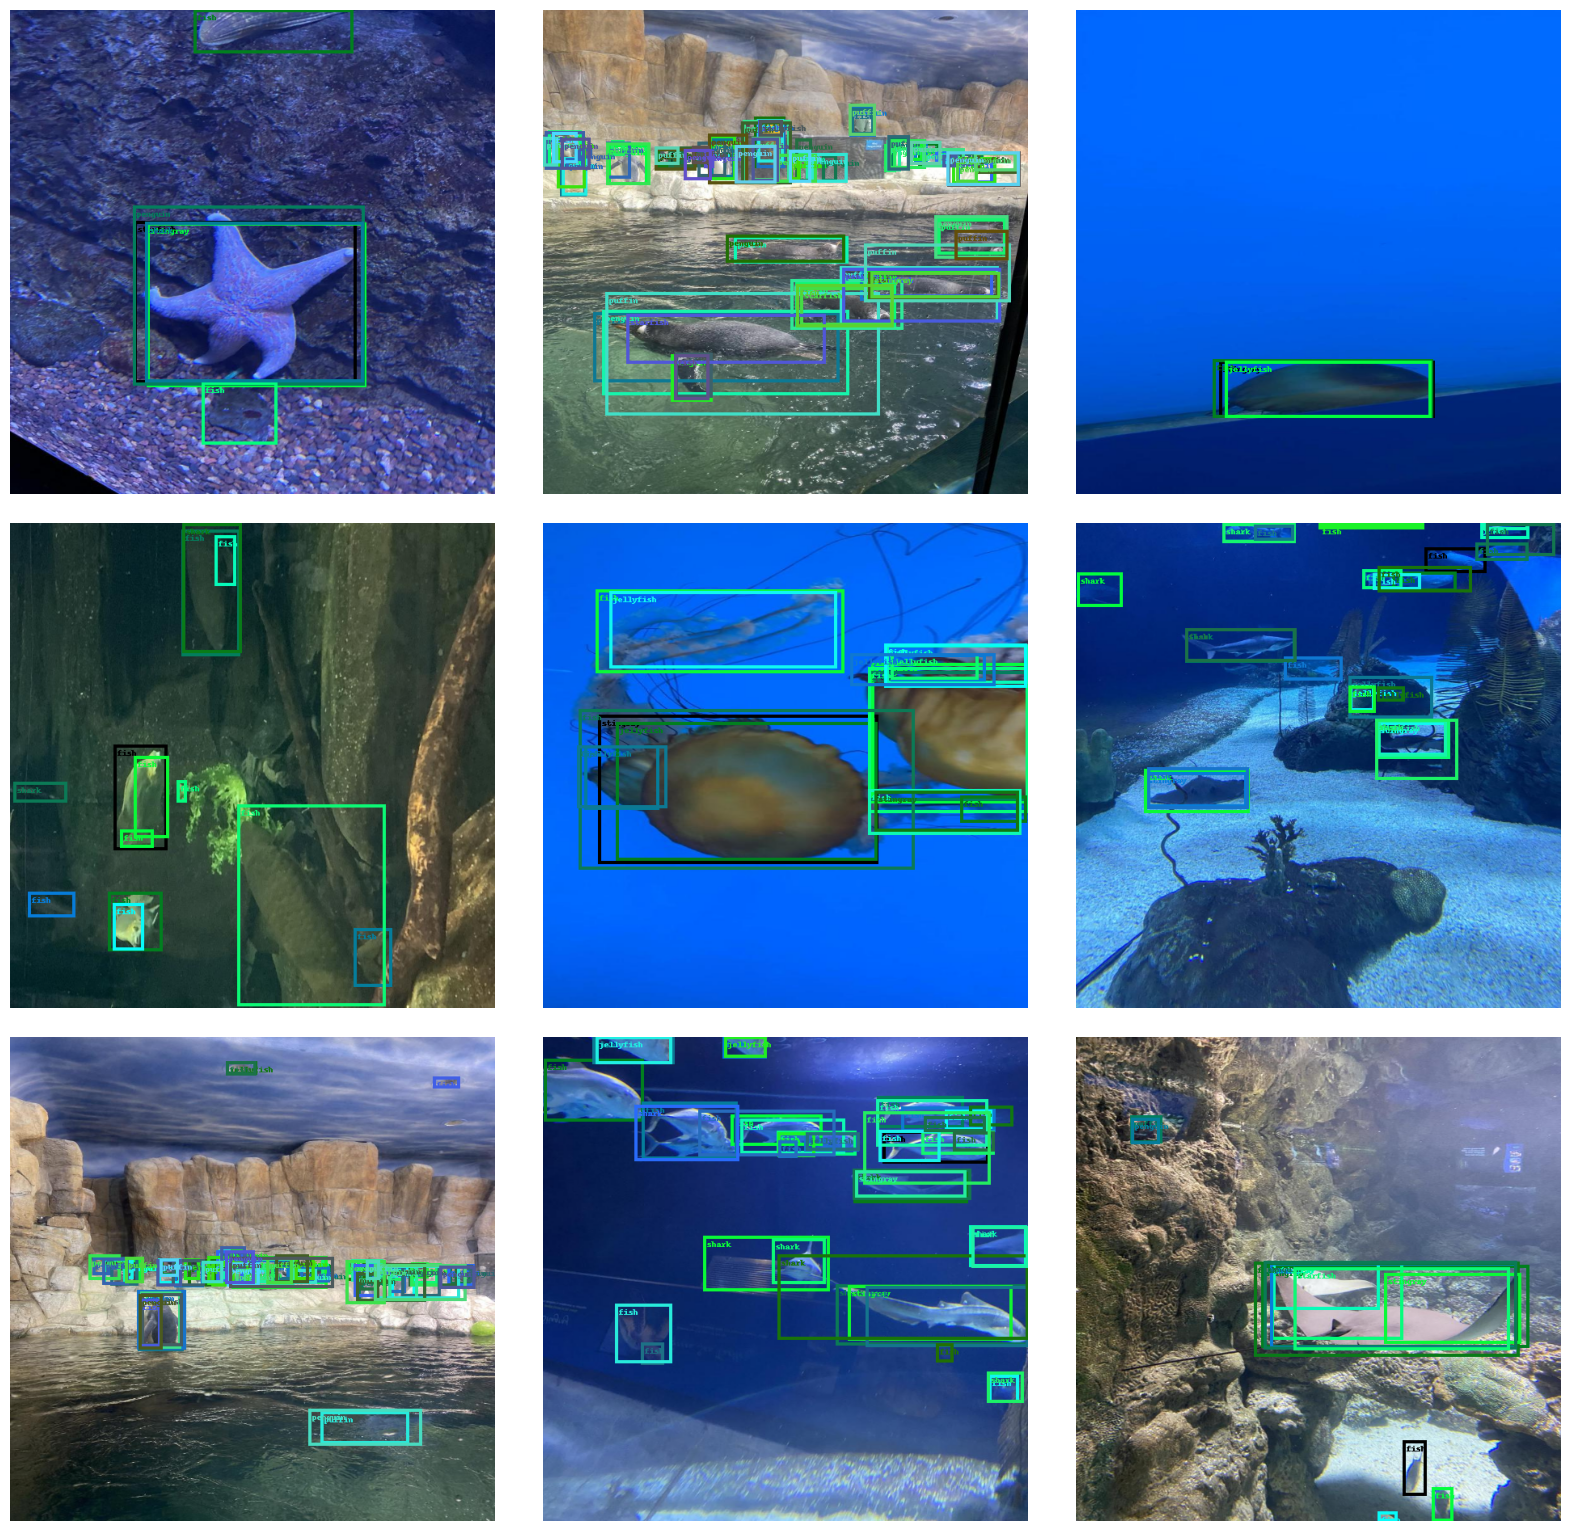

In [25]:
%matplotlib inline
fig, axs = plt.subplots(3,3, figsize=(20, 20))
fig.subplots_adjust(hspace = .0000005, wspace=.1)
axs = axs.ravel()
for i in range(9):
    img, _ = test_dataset[i]
    img_int = torch.tensor(img*255, dtype=torch.uint8)
    with torch.no_grad():
        prediction = model([img.to(device)])
        pred = prediction[0]
    axs[i].imshow(draw_bounding_boxes(
        img_int, pred['boxes'], [classes[i] for i in pred['labels']], width=4
    ).permute(1, 2, 0))
    axs[i].axis('off')

In [43]:
from torchmetrics.detection.mean_ap import MeanAveragePrecision

preds = []
for i in range(len(test_dataset)):

    try:
        img, _ = test_dataset[i]
        img_int = torch.tensor(img*255, dtype=torch.uint8)
        with torch.no_grad():
            prediction = model([img.to(device)])
            pred = prediction[0]
            pred['image_id'] = i
            preds.append(pred)

    except:
        print("error at", i)
        continue

preds


error at 10
error at 55


[{'boxes': tensor([[153.4882, 262.0290, 428.6645, 462.4117],
          [227.9309,   0.0000, 424.5396,  54.5839],
          [169.7992, 264.1539, 440.3254, 467.3619],
          [152.6687, 243.7054, 438.9481, 465.2123],
          [237.2423, 461.1400, 330.1874, 538.1487],
          [167.0768, 263.6893, 437.7725, 461.1979]], device='cuda:0'),
  'labels': tensor([6, 1, 7, 3, 1, 5], device='cuda:0'),
  'scores': tensor([0.9553, 0.1473, 0.0932, 0.0872, 0.0543, 0.0532], device='cuda:0'),
  'image_id': 0},
 {'boxes': tensor([[139.2253, 172.3999, 160.4601, 192.3705],
          [464.6038, 165.7694, 488.4132, 193.7523],
          [ 80.6905, 167.0060, 129.2533, 217.2426],
          [429.7600, 158.4572, 453.5948, 198.4718],
          [  6.2350, 150.3255,  47.9402, 198.9763],
          [207.4467, 160.2130, 237.2767, 208.6631],
          [505.7642, 178.9169, 519.2792, 193.6640],
          [459.2368, 165.8211, 475.5705, 188.6031],
          [490.3692, 179.2275, 500.2986, 195.2144],
          [187.7216, 

In [44]:
metric = MeanAveragePrecision(num_classes=n_classes)
target = []
for i in range(len(test_dataset)):
    try:
        target.append(test_dataset[i][1])

    except:
        print("error at", i)
        continue

#convert to gpu
target = [{k: v.to(device) for k, v in t.items()} for t in target]
metric.update(preds, target)
metric.compute()


error at 10
error at 55


{'map': tensor(0.3562),
 'map_50': tensor(0.6658),
 'map_75': tensor(0.3309),
 'map_small': tensor(0.2489),
 'map_medium': tensor(0.2928),
 'map_large': tensor(0.4321),
 'mar_1': tensor(0.1707),
 'mar_10': tensor(0.4293),
 'mar_100': tensor(0.5013),
 'mar_small': tensor(0.3826),
 'mar_medium': tensor(0.4699),
 'mar_large': tensor(0.5908),
 'map_per_class': tensor(-1.),
 'mar_100_per_class': tensor(-1.)}